In [1]:
%load_ext autoreload
%autoreload 2
import site
site.addsitedir('../') 

In [2]:
import sganalysiswf as sga

In [1]:
configfile = '/media/cephfs2/userdata/Bullock_group/Lucas/EXP.M20221012/KIF5B p150/config.json'
config = sga.load_config(configfile)
config['mode'] = 0
config['Analysis'] = 'Spread'
config['channels'] = [{'index':0,'name':'nuclei'},{'index':1,'name':'ch2'},{'index':2,'name':'ch3'},{'index':3,'name':'ch4'}]
config['mode'] = 1
fname = '/media/cephfs2/userdata/Bullock_group/Lucas/EXP.M20221012/KIF5B p150/U2OS siCNTRL AS Z Positions_Maximum intensity projection.lsm'
#fname = '/media/cephfs2/userdata/Bullock_group/Lucas/EXP.M20221012/KIF5B p150/U2OS siCNTRL CNTRL Z Positions_Maximum intensity projection.lsm'
stats, mip, labels, rois = sga.process_fov_spread(fname, 0, config)

NameError: name 'sga' is not defined

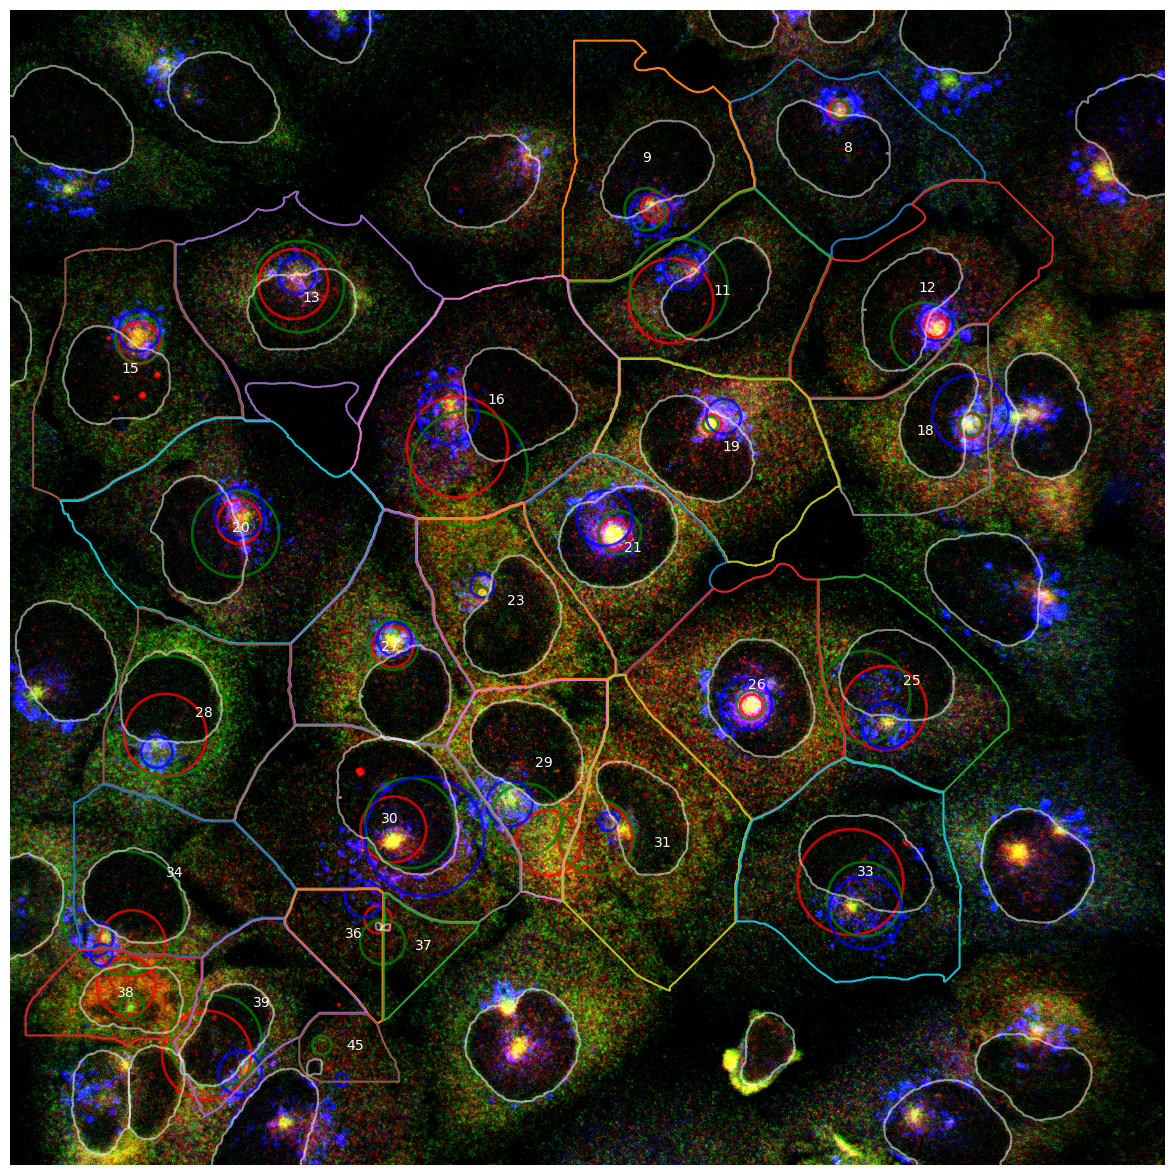

In [270]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
sga.show_image(mip, labels, rois, stats)

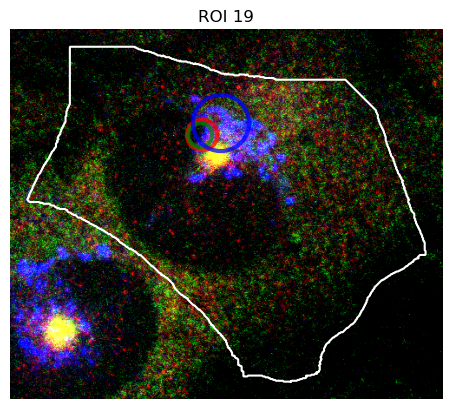

In [271]:
import math
import matplotlib.pyplot as plt
roi = rois[8]
masks, crop_img = sga.compute_roi_masks(roi, labels, mip, border=0)
distances = sga.compute_roi_distance(masks)
stat = sga.measure_roi_spread(roi, crop_img, masks, distances)
#s  = sga.spatial_spread_mask(masks['cell'], crop_img['other'])
plt.figure()
sga.show_roi(roi, mip, labels, stat)


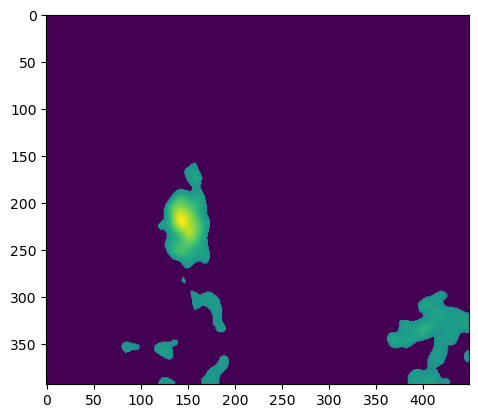

In [245]:
tmp = gaussian_filter(crop_img['ch2'], 5)
tmp = tmp * (tmp > tmp.max()/2)
plt.imshow(tmp)

## Second dataset

In [ ]:
config

In [ ]:
configfile = '/media/cephfs2/userdata/Bullock_group/Lucas/EXP.M20230114/config.json'
#config = json.load(open(configfile))
config['channels'][1]={'index': 3, 'name': 'membrane'}
fname = '/media/cephfs2/userdata/Bullock_group/Lucas/EXP.M20230114/U2OS siCNTRL AS Z Positions_Maximum intensity projection EEA1 KIF.lsm'
stats, mip, labels, rois = sga.process_fov(fname,0,config)
sga.show_image(mip, labels, rois)


In [33]:
roi=rois[16]
masks, crop_img = sga.compute_roi_masks(roi, labels, mip, border=0)
distances = sga.compute_roi_distance(masks)
stat = sga.measure_roi_stats(roi, crop_img, masks, distances)

plt.imshow(crop_img['granule']+100*masks['cell']+masks['particle'])
sga.spatial_spread(masks['cell'], crop_img['other'])


KeyError: 'particle'

In [32]:
from skimage import morphology
from skimage.filters.rank import maximum, minimum
from skimage.filters import gaussian
from timeit import default_timer as timer

# We define a structuring element (flat kernel) with radius 30
im = crop_img['granule']
corrected = morphology.white_tophat(im, morphology.disk(10))

def spatial_spread(mask, intensity):
    """Spread as the trace of the moment matrix"""
    import numpy as np
    x,y = np.meshgrid(np.arange(mask.shape[1]), np.arange(mask.shape[0]))
    w = mask * intensity    
    #if (w.max()-w.min()) > 0 :
    #    w = (w - w.min()) / (w.max() - w.min())
    #else:
    #    return 0

    sw = np.sum(w)    
    if sw < 1e-9:
        return 0.0
    sx = np.sum(w * x) / sw
    sy = np.sum(w * y) / sw    
    sxx = np.sum(w * np.square(x-sx)) / sw
    syy = np.sum(w * np.square(y-sy)) / sw
    
    #sxy = np.sum(w * (x-sx) * (y-sy)) / sw
    return np.sqrt(sxx+syy)

tmp =  corrected*(corrected>20)
plt.imshow(tmp * masks['cell'])

spatial_spread(masks['cell']>0, tmp)



KeyError: 'granule'

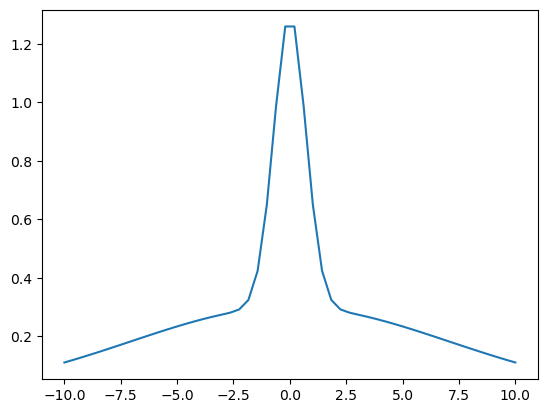

In [54]:
import numpy as np
x = np.linspace(-10,10)
y = np.exp(-x**2) + 0.3*np.exp(-0.01*x**2)
plt.plot(x,y)


In [249]:
import numpy.ma as ma
from scipy.optimize import minimize_scalar
def characteristic_radius(intensity, mask, fraction):
    """radius corresponding to a fraction of the total intensity 

    Issue: the center is not well defined..
    """
    x0 = np.arange(mask.shape[1])
    y0 = np.arange(mask.shape[0])
    x,y = np.meshgrid(x0,y0)    
    w = ma.array(intensity-intensity.min(), mask = np.logical_not(mask))
    x = ma.array(x, mask = np.logical_not(mask))
    y = ma.array(y, mask = np.logical_not(mask))   
    sw = np.sum(w)
    #Fx = np.array([(w * (x < v)).sum() / sw for v in x0])
    #sx1 = np.interp(0.5, Fx, x0)
    #Fy = np.array([(w * (y < v)).sum() / sw for v in y0])
    #sy1 = np.interp(0.5, Fy, y0)
    ret = np.unravel_index(np.argmax(w), w.shape)    
    sx1 = ret[1]
    sy1 = ret[0]    
    d = np.sqrt(np.square(x - sx1) + np.square(y - sy1))
    r = np.linspace(0, d.max(), 100)
    F = np.array([(w * (d < v)).sum() / sw for v in r])    
    r0 = np.interp(fraction, F, r)
    return r0    

from scipy.ndimage import gaussian_filter
tmp = gaussian_filter(crop_img['ch2'], 1)
characteristic_radius(tmp, masks['cell'],0.1)

43.68665796764612

In [254]:
def fraction_in_spot(mask, intensity):
    score = gaussian_filter(intensity,2) - gaussian_filter(intensity,10)
    m = np.median(score)
    s = 1.48*np.median(np.abs(score-m))
    score = score > (m + 3 * s)
    score = score * mask
    return (intensity*score).sum() / (intensity*mask).sum()

fraction_in_spot(masks['cell'], crop_img['ch2'])



0.39034335966322226

79.69229921410262


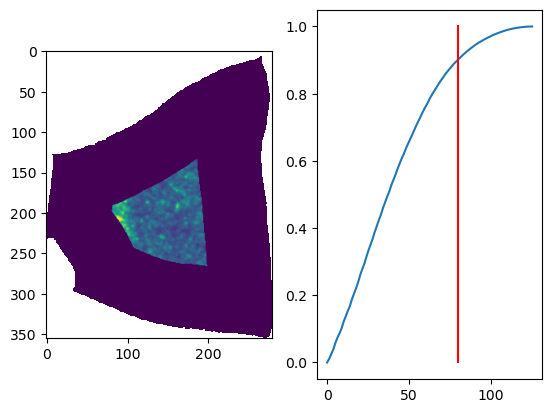

In [227]:
import numpy.ma as ma
from scipy.optimize import minimize_scalar
def characteristic_distance(intensity, mask, distance, fraction):
    """Radius corresponding to a fraction of the total intensity 
    """    
    w = ma.array(intensity-intensity.min(), mask = np.logical_not(mask))        
    sw = np.sum(w)
    r = np.linspace(0, distance.max(), 100)
    F = np.array([(w * (distance < v)).sum() / sw for v in r])          
    r0 = np.interp(fraction, F, r)
    print(r0)
    plt.subplot(121)
    plt.imshow(w * (distance > r0))    
    plt.subplot(122)
    plt.plot(r,F)
    plt.plot([r0,r0],[0,1],'r')

from scipy.ndimage import gaussian_filter
tmp = gaussian_filter(crop_img['ch2'], 1)
characteristic_distance(tmp, masks['cell'],distances['membrane'], 0.9)

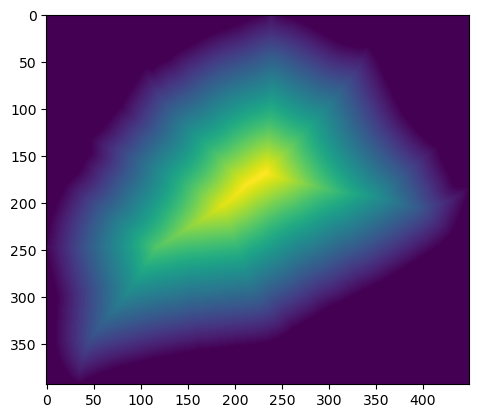

In [180]:
plt.imshow(distances['membrane'])


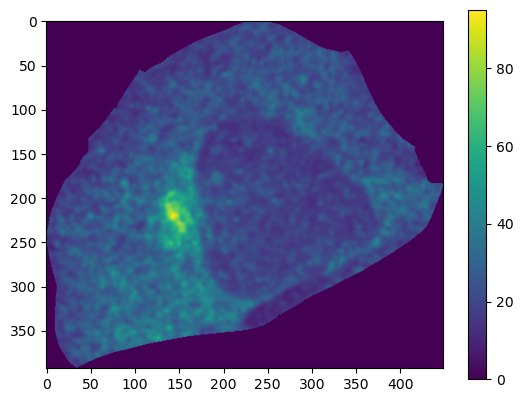

In [77]:
from scipy.ndimage import gaussian_filter
tmp = gaussian_filter(crop_img['ch2'], 2)
plt.imshow(tmp*masks['cell'])
plt.colorbar()
#plt.hist(np.log(0.1+tmp.ravel()),bins=100)

14348740.351654148